In [57]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [58]:
# Defining Classes
classes = [
    [-1,-0.9],
    [-0.9,-0.8],
    [-0.8,-0.7],
    [-0.7,-0.6],
    [-0.6,-0.5],
    [-0.5,-0.4],
    [-0.4,-0.3],
    [-0.3,-0.2],
    [-0.2,-0.1],
    [-0.1,0.0],
    [0.0,0.1],
    [0.1,0.2],
    [0.2,0.3],
    [0.3,0.4],
    [0.4,0.5],
    [0.5,0.6],
    [0.6,0.7],
    [0.7,0.8],
    [0.8,0.9],
    [0.9,1.0]
]

In [59]:
class ControlsDataset(Dataset):
    """Dataset that maps camera images into steering angle"""
    def __init__(self, stack_size = 1 ,img_folder = 'data/', csv_path='data/data.csv', classes=classes):
        self.stack_size = stack_size
        self.img_folder = img_folder
        # index_col = 0 so panda does not choose its own indexing
        self.classes = classes
        self.data_frame = pd.read_csv(csv_path)
            
    def __len__(self):
        return len(self.data_frame) - self.stack_size
    
    def __getitem__(self, idx):
        img_filenames = ["{0}{1:06d}.jpg".format(self.img_folder, i) 
                            for i in range(idx, idx+self.stack_size)]
        imgs = [io.imread(img_filename).transpose((2,0,1)) for img_filename in img_filenames]
        img_stack = np.concatenate(imgs, axis=0)
        
        # use the latest image as the control
        control = self.data_frame.iloc[idx+self.stack_size,0]
        control = np.array([control])
        
        sample = {'image': img_stack, 
                  'control': control}
        
        return sample
    
    def convertTOClass(self):
        def myfunc(x):
            for i in range(len(self.classes)):
                start = self.classes[i][0]
                end = self.classes[i][1]
                if start == -1 and (x >= start and x <= end):
                    return i
                elif x > start and x <= end:
                    return i
        self.data_frame.columns = ['img', 'steeringAng']
        self.data_frame['steeringAng'] = self.data_frame.apply(lambda x: myfunc(x.steeringAng), axis=1)
        

In [60]:
dataset = ControlsDataset(stack_size = 5)
dataset.convertTOClass()
dataloader = DataLoader(dataset, batch_size = 4, shuffle = True, num_workers = 0)

dataset[0]['image'].shape


(15, 480, 640)

In [61]:
print(dataset.data_frame.head(10))

   img  steeringAng
0    1            9
1    2            9
2    3            9
3    4            9
4    5            9
5    6            9
6    7            9
7    8            9
8    9            9
9   10            9


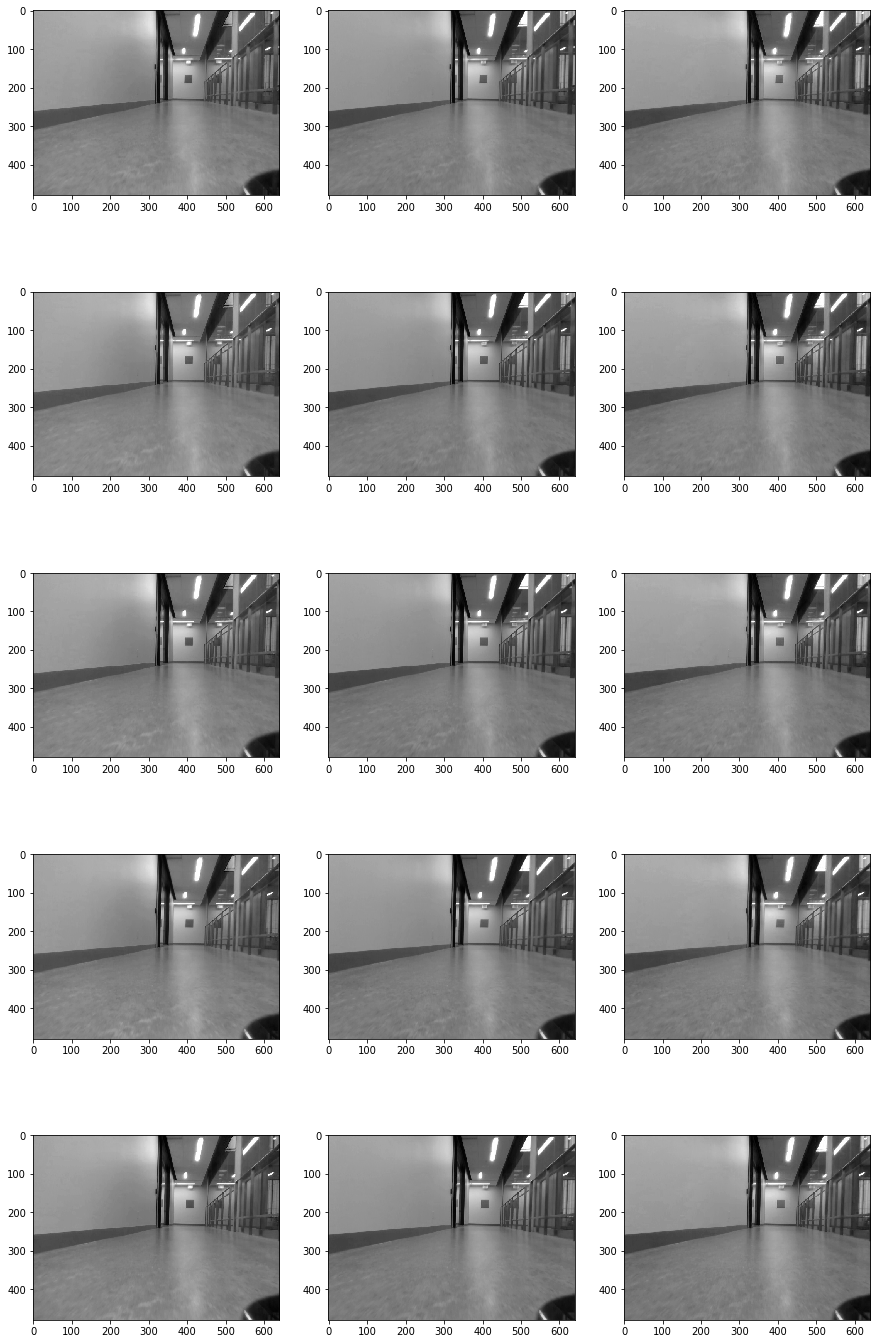

In [56]:
img_stack = dataset[100]['image']

f, ax = plt.subplots(5, 3, figsize=(15,25))
for k in range(15):
    i,j = k//3, k % 3
    ax[i,j].imshow(img_stack[k],cmap='gray')